# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/cce06496ff4de712518853d0e08e639b1d133f79a30a16842d02f786.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Esslingen am Neckar, Baden-Württemberg Region, Germany**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
import matplotlib.dates as dates
import matplotlib.ticker as ticker

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

#leaflet_plot_stations(400,'cce06496ff4de712518853d0e08e639b1d133f79a30a16842d02f786')

In [2]:
data_path = 'data/C2A2_data/BinnedCsvs_d400/cce06496ff4de712518853d0e08e639b1d133f79a30a16842d02f786.csv'

# Load data and parse date column as dates
climate_data = pd.read_csv(data_path)
climate_data.Date = pd.to_datetime(climate_data.Date)

# Separate dates
climate_data['Year'] = climate_data.Date.dt.year
climate_data['Month'] = climate_data.Date.dt.month
climate_data['Day'] = climate_data.Date.dt.day

# Convert temperatures to Celsius
to_celsius = lambda x: x/10.
climate_data.Data_Value = climate_data.Data_Value.apply(to_celsius)

# Sort
climate_data.set_index(['Month','Day'],inplace=True)
climate_data.sort_index(inplace=True)

# Remove leap days
is_leap_day = lambda x: (x.month == 2) & (x.day == 29)
leap_day_mask = climate_data.Date.apply(is_leap_day)
leapless_climate_data = climate_data[~leap_day_mask]


In [3]:
# Select climate data for years 2005-2014
range_mask = (leapless_climate_data.Year >= 2005) & (leapless_climate_data.Year <= 2014)
range_climate_data = leapless_climate_data[range_mask]

# Separate out TMAX and TMIN
max_temp_mask = range_climate_data['Element'] == 'TMAX'
min_temp_mask = range_climate_data['Element'] == 'TMIN'
max_temp = range_climate_data[max_temp_mask]
min_temp = range_climate_data[min_temp_mask]

# Get daily max and min temperature for range
range_max_temp = max_temp.groupby(level=['Month','Day'])['Data_Value'].max()
range_min_temp = min_temp.groupby(level=['Month','Day'])['Data_Value'].min()



In [4]:

# Get max and min temp for 2015
year_2015_mask = leapless_climate_data.Year == 2015
year_2015_data = leapless_climate_data[year_2015_mask]

# Separate out TMAX and TMIN
year_2015_max_mask = year_2015_data.Element == 'TMAX'
year_2015_min_mask = year_2015_data.Element == 'TMIN'
year_2015_max_temp = year_2015_data[year_2015_max_mask]
year_2015_min_temp = year_2015_data[year_2015_min_mask]

# Get daily max and min temperature for 2015
year_2015_daily_max_temp = year_2015_max_temp.groupby(level=['Month','Day'])['Date','Data_Value'].max()
year_2015_daily_min_temp = year_2015_min_temp.groupby(level=['Month','Day'])['Date','Data_Value'].min()


In [5]:
# Get 2015 record days
year_2015_record_max_mask = year_2015_daily_max_temp.Data_Value.values > range_max_temp.values
year_2015_record_min_mask = year_2015_daily_min_temp.Data_Value.values < range_min_temp.values

record_2015_max_temp = year_2015_daily_max_temp[year_2015_record_max_mask]
record_2015_min_temp = year_2015_daily_min_temp[year_2015_record_min_mask]


In [6]:
# Get dates for plotting. Use 2015 since year does not matter for representation
date_range = year_2015_data.Date.unique()


<IPython.core.display.Javascript object>


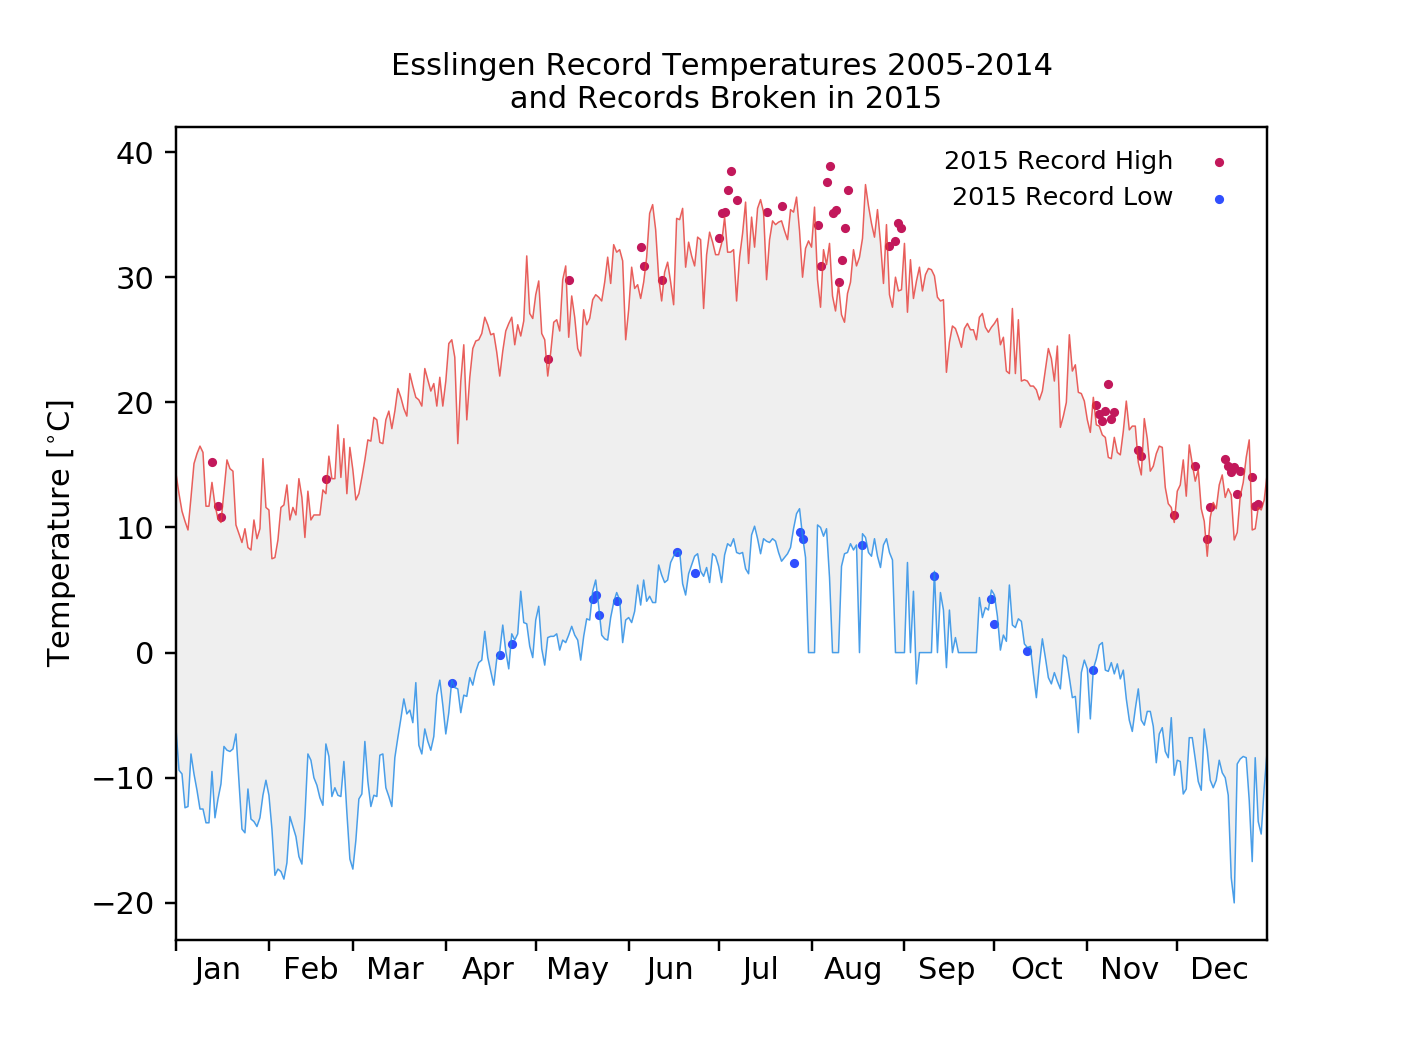

In [7]:
# Plot everything
%matplotlib notebook

# Plot range daily max and min temps with range filled
plt.plot(date_range,range_max_temp.values,c='#E53935',alpha=0.8,linewidth=0.5,label=None)
plt.plot(date_range,range_min_temp.values,c='#1E88E5',alpha=0.8,linewidth=0.5,label=None)
plt.gca().fill_between(date_range,range_min_temp.values,range_max_temp.values,facecolor='#E0E0E0',alpha=0.5)

# Do scatter plot for record breaking temperatures in 2015
plt.scatter(record_2015_max_temp.Date.values,record_2015_max_temp.Data_Value.values,
            marker='o',c='#C2185B',s=4,label='2015 Record High')
plt.scatter(record_2015_min_temp.Date.values,record_2015_min_temp.Data_Value.values,
            marker='o',c='#304FFE',s=4,label='2015 Record Low')

In [8]:
# Clean up the axes

ax = plt.gca()
ax.set_xlim(date_range[0],date_range[-1])

# Set xtics to coincide with the month (and mid-month for minor ticks)
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))

# Format the xlabels to be that of the month names at the center of each month
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# Remove minor xtick lines
xticks = ax.xaxis.get_minor_ticks()
for xtick in xticks:
    xtick.tick1line.set_markersize(0)
    xtick.tick2line.set_markersize(0)

# Set y-axis label
ax.set_ylabel('Temperature [$^{\circ}$C]')



In [9]:
# Legend Stuff
ax.legend(fontsize='small',markerfirst=False,edgecolor='#ffffff')

In [10]:
# Title
plt.title("Esslingen Record Temperatures 2005-2014\n and Records Broken in 2015",fontsize='medium')